In [57]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier 

# Build and test a Nearest Neighbors classifier.

- We will try to build the best possible nearest neighbors classifier for a specific data set. By 'best', we mean _highest accuracy_
- Use a train/dev/test split
- Experiment with as many hyper-parameters as possible



### Load the Iris data

Load the Iris data to use for experiments. The data include 50 observations of each of 3 types of irises (150 total). Each observation includes 4 measurements: sepal and petal width and height. The goal is to predict the iris type from these measurements.

<http://en.wikipedia.org/wiki/Iris_flower_data_set>

In [58]:
# Load the data, which is included in sklearn.
iris = load_iris()
print 'Iris target names:', iris.target_names
print 'Iris feature names:', iris.feature_names
X, y = iris.data, iris.target

Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### Take a quick look at the data

In [59]:
print X.shape
print X[:5]
print y

(150, 4)
[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


This data is fairly well behaved. For now, we are going to skip EDA and feature engineering---which would normally be essential steps

### Break off a test set

In [60]:
np.random.seed(0)

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
test_size = 50  # 1/3 of the data
test_idx = np.random.choice(X.shape[0], test_size, replace=False)
train_idx = np.setdiff1d(range(X.shape[0]), test_idx)

# Split into train and test.
X_train, y_train = X[train_idx, :], y[train_idx]
X_test, y_test = X[test_idx, :], y[test_idx]

At this point, we set aside the test set. We should only touch the test set once!

### Split the training set into development train/test

In [61]:
np.random.seed(1)

dev_size = 30
devtest_idx = np.random.choice(train_idx, dev_size, replace=False)
devtrain_idx = np.setdiff1d(train_idx, devtest_idx)

# Split into train and dev.
X_devtrain, y_devtrain = X[devtrain_idx, :], y[devtrain_idx]
X_devtest, y_devtest = X[devtest_idx, :], y[devtest_idx]

In [62]:
print X.shape
print X_test.shape
print X_train.shape
print X_devtrain.shape
print X_devtest.shape

(150, 4)
(50, 4)
(100, 4)
(70, 4)
(30, 4)


## Implement K Nearest Neighbors

### Implement a distance function

Create a distance function that returns the distance between 2 observations.

In [63]:
def EuclideanDistance(v1, v2):
    sum = 0.0
    for index in range(len(v1)):
        sum += (v1[index] - v2[index]) ** 2
    return sum ** 0.5

Just for fun, let's compute all the pairwise distances in the training data and plot a histogram.

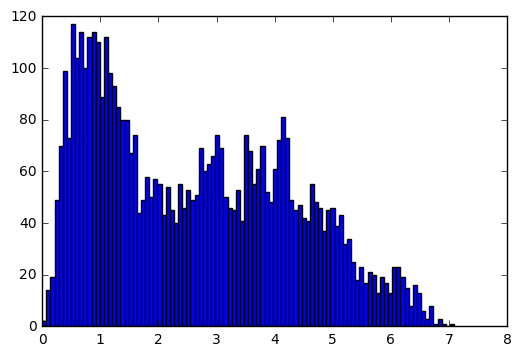

In [64]:
dists = []
for i in range(len(X_train) - 1):
    for j in range(i + 1, len(X_train)):
        dist = EuclideanDistance(X_train[i], X_train[j])
        dists.append(dist)
        
fig = plt.hist(dists, 100)

##### Nicer Versions of the above two cells

Python is great for data science because there are a ton of high-level, commonly used, and often vectorized operations

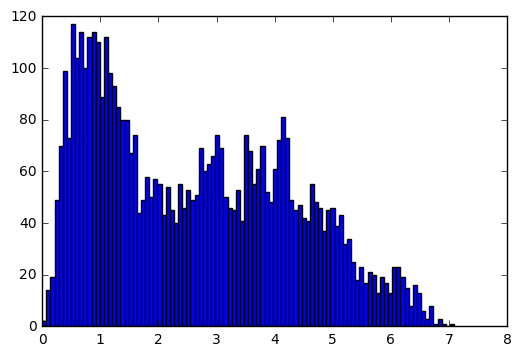

In [65]:
# Use vectorized numpy functions
def EucliceanDistance(v1, v2):
    dist = np.sum((v1 - v2) ** 2) ** 0.5
    return dist

# There should be a function for this
from scipy.spatial.distance import pdist
dists = pdist(X_train, 'euclidean')

fig = plt.hist(dists, 100)

### 1-NN Classifier

Ok now let's create a class that implements a Nearest Neighbors classifier. We'll model it after the sklearn classifier implementations, with fit() and predict() methods.

<http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier>

In [66]:
from scipy.spatial.distance import cdist

class NearestNeighbors:
    
    def __init__(self, metric=EuclideanDistance):
        self.metric = metric
        
    def fit(self, data, labels):
        self.train_data = data
        self.train_labels = labels
        
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
        return results
    
    def _predict_item(self, item):
        """
        Return the label of the training example closest to item
        """
        distances = cdist([item], self.train_data, self.metric)
        best_label = self.train_labels[np.argmin(distances)]
        return best_label

#### Test

See how well the classifier performs

In [67]:
clf = NearestNeighbors()
clf.fit(X_devtrain, y_devtrain)
preds = clf.predict(X_devtest)

correct = np.sum(preds==y_devtest)
total = len(y_devtest)
print 'total: {}  correct: {}  accuracy: {:.3}'.format(total, correct, 1.0 * correct / total)

total: 30  correct: 29  accuracy: 0.967


### k nearest neighbors

The implementation above only allows for a single nearest neighbor; that is, the classifier predicts the label of the closest available point. What about using more than one nearest neighbor. Typically, this means to make a prediciton we:

1. Find the k closest points (according to our distance metric) to the query point.
2. Find the majority label of those k points found in (1)
3. Return the label in (2) as the prediction

Try implementing this strategy below.
Hint: Check out the `most_common` method in `Counter`

In [68]:
from collections import Counter

class OurKNearestNeighbors:
    # Initialize an instance of the class.
    def __init__(self, k, metric=EuclideanDistance):
        self.metric = metric
        self.k = k
    
    # No training for Nearest Neighbors. Just store the data.
    def fit(self, train_data, train_labels):
        self.train_data = train_data
        self.train_labels = train_labels
    
    # Make predictions for each test example and return results.
    def predict(self, test_data):
        results = [self._predict_item(item) for item in test_data]
        return results
    
    # Private function for making a single prediction using KNN.
    def _predict_item(self, item):
        dists = cdist([item], self.train_data, self.metric).flatten()
        k_closest = self.train_labels[np.argsort(dists)][:self.k]
        best_label = Counter(k_closest).most_common(1)[0][0]
        return best_label

#### Test

`NearestNeighbors` and `OurKNearestNeighbors` should give the same prediction

In [69]:
clfk = OurKNearestNeighbors(k=1)
clfk.fit(X_devtrain, y_devtrain)
preds = clfk.predict(X_devtest)

# test
clf = NearestNeighbors()
clf.fit(X_devtrain, y_devtrain)
preds_nn = clf.predict(X_devtest)

print "Percentage of same predictions: ", np.mean(preds == preds_nn)

Percentage of same predictions:  1.0


### Picking k: the number of neighbors to use in classification

Implement a way to pick the number of neighbors to use in the classifier. We already have a test set, so simply extend the procedure in the previous code cell to run over different numbers of neighbors. Plot the test set performance versus the number of neighbors.

In [70]:
## code goes here!

for k in range(1, 15):
    clfk = OurKNearestNeighbors(k=k)
    clfk.fit(X_devtrain, y_devtrain)
    preds = clfk.predict(X_devtest)
    
    print "k = {} ; accuracy: {:.4}".format(k, np.mean(preds == y_devtest))

k = 1 ; accuracy: 0.9667
k = 2 ; accuracy: 0.9333
k = 3 ; accuracy: 0.9667
k = 4 ; accuracy: 1.0
k = 5 ; accuracy: 0.9667
k = 6 ; accuracy: 0.9667
k = 7 ; accuracy: 0.9667
k = 8 ; accuracy: 0.9667
k = 9 ; accuracy: 0.9667
k = 10 ; accuracy: 0.9667
k = 11 ; accuracy: 0.9667
k = 12 ; accuracy: 0.9667
k = 13 ; accuracy: 0.9667
k = 14 ; accuracy: 0.9667


### This isn't really enough information. Let's try using more train/dev splits

Step 1 - Write a function that splits a training dataset randomly, builds a kNN classifier, and reports the acccuracy

In [71]:
from sklearn.cross_validation import train_test_split
import pdb

def split_and_knn_classifier(data, labels, k, test_size=test_size):
    
    # Set aside the index
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=test_size)
    
    # Build a KNN classifier and record the accuracy
    clfk = OurKNearestNeighbors(k=k, metric='euclidean')
    clfk.fit(train_data, train_labels)
    preds = clfk.predict(test_data)
    accuracy = np.mean(preds == test_labels)
    
    return accuracy

split_and_knn_classifier(X_train, y_train, k=1, test_size=20)
    

0.84999999999999998

Step 2 - Run the above function 500 times for each value of k between 1 and 15 to get the mean test accuracy for that value of k

In [77]:
accuracy = []
for k in range(1, 20):
    mean_accuracy = np.mean([split_and_knn_classifier(X_train, y_train, k, test_size=20) for i in range(1000)])
    print "k = {}, mean_accuracy = {:.3}".format(k, mean_accuracy)
    accuracy.append(mean_accuracy)

k = 1, mean_accuracy = 0.954
k = 2, mean_accuracy = 0.942
k = 3, mean_accuracy = 0.951
k = 4, mean_accuracy = 0.955
k = 5, mean_accuracy = 0.963
k = 6, mean_accuracy = 0.957
k = 7, mean_accuracy = 0.947
k = 8, mean_accuracy = 0.957
k = 9, mean_accuracy = 0.95
k = 10, mean_accuracy = 0.957
k = 11, mean_accuracy = 0.949
k = 12, mean_accuracy = 0.952
k = 13, mean_accuracy = 0.948
k = 14, mean_accuracy = 0.949
k = 15, mean_accuracy = 0.937
k = 16, mean_accuracy = 0.931
k = 17, mean_accuracy = 0.924
k = 18, mean_accuracy = 0.917
k = 19, mean_accuracy = 0.909


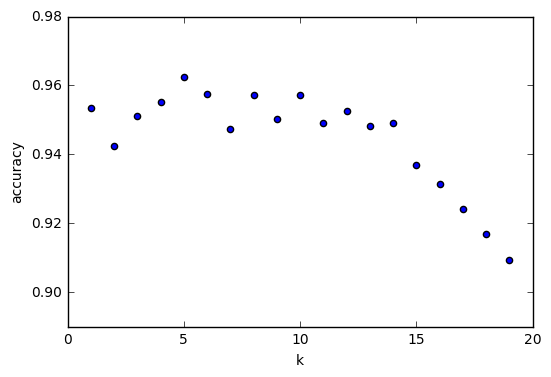

In [89]:
import pandas as pd
pd.DataFrame({'k': range(1,20), 'accuracy': accuracy}).plot(kind='scatter', x='k', y='accuracy')

Step 3 (optional) - If you would like, now would be the time to experiment with different distance metrics. Repeat the above step and see what the results look like

### Deployment

Use Occam's razor to select the best model.

Once you have chosen the hyper-parameters for the model (k and distance metric), it is time to deploy the model. Now is the time to test our model on the test set, so that we know what to expect after deployment.

In [73]:
metric = 'euclidean'
k = 10
finalclf = OurKNearestNeighbors(k=k, metric=metric)
finalclf.fit(X_train, y_train)
preds = finalclf.predict(X_test)
accuracy = np.mean(preds == y_test)

print accuracy

0.98


Note: Before deploying the model, we could actually incorporate the test data into our training set. The only thing that matters now, is how well the model generalizes in the real world.

### Visualizing the results

We've been a litte haphazard so far, we should have plotted the data and some results to get an idea of how the algorithm is performing. Plot the data with the true labels as colors, and plot it with some fitted labels, for differing values of k, to see how our KNN algorithm is performing.

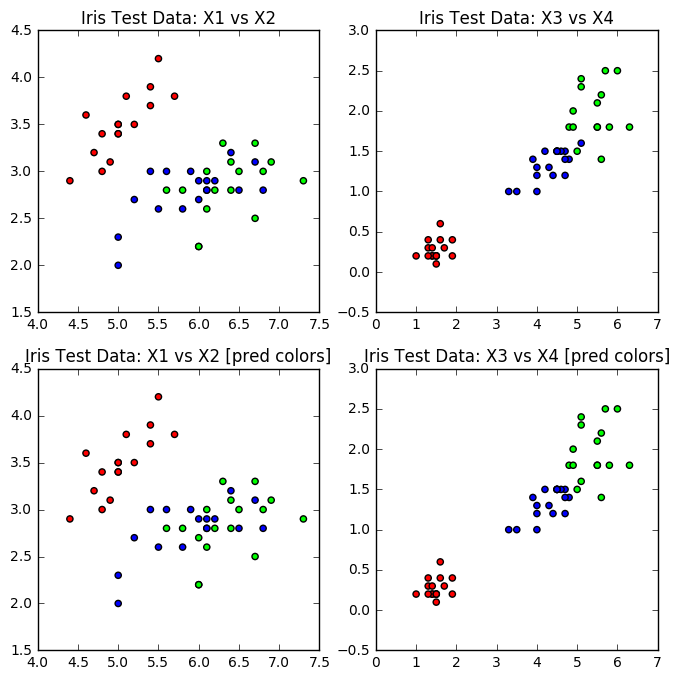

In [74]:
k = 10

# clfk = OurKNearestNeighbors(k=k)
# clfk.fit(train_data, train_labels)
# preds = clfk.predict(test_data)

cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])

plt.figure(figsize=(8,8)) 
p = plt.subplot(2, 2, 1)
p.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright)
plt.title("Iris Test Data: X1 vs X2")

p = plt.subplot(2, 2, 2)
p.scatter(X_test[:, 2], X_test[:, 3], c=y_test, cmap=cm_bright)
plt.title("Iris Test Data: X3 vs X4")

p = plt.subplot(2, 2, 3)
p.scatter(X_test[:, 0], X_test[:, 1], c=preds, cmap=cm_bright)
plt.title("Iris Test Data: X1 vs X2 [pred colors]")

p = plt.subplot(2, 2, 4)
p.scatter(X_test[:, 2], X_test[:, 3], c=preds, cmap=cm_bright)
plt.title("Iris Test Data: X3 vs X4 [pred colors]")

## Bonus: Implement variable scaling. 

That is, scale each feature to its normalized z-score. Make sure not to contaminate the test set..

Repeat steps one and two above

Step 1

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def split_and_knn_classifier(data, labels, k, test_size=test_size):
    
    # Set aside the index
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=test_size)
    
    # Build a KNN classifier and record the accuracy
    ss = StandardScaler()
    clfk = OurKNearestNeighbors(k=k, metric='euclidean')
    pipeline = Pipeline([('scale', ss), ('knn', clfk)])
    pipeline.fit(train_data, train_labels)
    preds = pipeline.predict(test_data)
    accuracy = np.mean(preds == test_labels)
    
    return accuracy

split_and_knn_classifier(X_train, y_train, k=1, test_size=20)

1.0

Step 2

In [76]:
for k in range(1, 20):
    mean_accuracy = np.mean([split_and_knn_classifier(X_train, y_train, k, test_size=20) for i in range(1000)])
    print "k = {}, mean_accuracy = {:.3}".format(k, mean_accuracy)

k = 1, mean_accuracy = 0.952
k = 2, mean_accuracy = 0.942
k = 3, mean_accuracy = 0.952
k = 4, mean_accuracy = 0.952
k = 5, mean_accuracy = 0.961
k = 6, mean_accuracy = 0.957
k = 7, mean_accuracy = 0.949
k = 8, mean_accuracy = 0.954
k = 9, mean_accuracy = 0.948
k = 10, mean_accuracy = 0.953
k = 11, mean_accuracy = 0.951
k = 12, mean_accuracy = 0.957
k = 13, mean_accuracy = 0.946
k = 14, mean_accuracy = 0.948
k = 15, mean_accuracy = 0.937
k = 16, mean_accuracy = 0.929
k = 17, mean_accuracy = 0.924
k = 18, mean_accuracy = 0.914
k = 19, mean_accuracy = 0.908


Question: Did variable scaling improve anything? Why or why not?

Question: What are some other things you could try? (In the context of K nearest neighbors)